IMPORT LIB

In [1]:
import pickle
import numpy as np

#dimension reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

# clustering 
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

#affichage
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg

/home/thomas.guerin@Digital-Grenoble.local/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-26 09:10:35.495566: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 09:10:36.788667: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly import offline

ModuleNotFoundError: No module named 'plotly'

CHARGEMENT emb_raw

In [3]:
with open('../data/embeddings/emb_raw.pckl', 'rb') as f:
    emb_raw = pickle.load(f)
print(len(list(emb_raw)))

32960


In [4]:
# get a list of the filenames
filenames = np.array(list(emb_raw.keys()))

# get a list of the raw embeddings
feat = np.array(list(emb_raw.values()))
feat = feat.reshape(-1,4096)

REDUCTION DIMENSION    
(PCA n=200 -> 79.2% d'explicabilité)   
(umap n=100 semble bien marcher)

In [5]:
#umap
reducer = UMAP(n_components=100, random_state=42)
x_umap = reducer.fit_transform(feat)

In [6]:
#pca
# pca = PCA(n_components=200, random_state=22)
# pca.fit(feat)
# x = pca.transform(feat)
# sum(pca.explained_variance_ratio_)

ENREGISTREMENT emb_light

In [7]:
emb_light={}
for i, name in enumerate(filenames):
    emb_light[name] = x_umap[i];

with open('emb_light.pckl', 'wb') as f:
    pickle.dump(emb_light, f)

COSIN SIMILILARITIES

In [8]:
# Calculate the cosine similarity matrix
# cosine_sim = cosine_similarity(x)
cosine_sim = cosine_similarity(x_umap)

CLUSTERING

In [9]:
kmeans = KMeans(n_clusters=2, random_state=42)
# kmeans.fit(x)
# kmeans.fit(x_umap)
kmeans.fit(cosine_sim)

/home/thomas.guerin@Digital-Grenoble.local/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2, random_state=42)

In [10]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)
        
print(f"sur {len(emb_raw)} images analysées.")
print(f"il y a {len(groups)} clusters.\n")

for i in range(len(groups)):
    print(f"Nb images dans le {i}eme cluster : {len(groups[i])}")

sur 32960 images analysées.
il y a 2 clusters.

Nb images dans le 0eme cluster : 17188
Nb images dans le 1eme cluster : 15772


REDUCTION 2D

In [11]:
# pca2 = PCA(n_components=2)
# xx = pca2.fit_transform(x)

# tsne = TSNE(n_components=2)
# xx = tsne.fit_transform(x)

umap2 = UMAP(n_components=2)
xx = umap2.fit_transform(x_umap)

ENREGISTREMENT pickle_2D

In [12]:
emb_2D={}
for i, name in enumerate(filenames):
    emb_2D[name] = xx[i];

with open('emb_2D.pckl', 'wb') as f:
    pickle.dump(emb_2D, f)

In [61]:
with open('../data/embeddings/emb_2D.pckl', 'rb') as f:
    emb_2D = pickle.load(f)

SEPARATION PAR CLUSTER ET PLOT

In [13]:
xx0 = xx[kmeans.labels_ == 0]
len(xx0)

17188

In [14]:
xx1 = xx[kmeans.labels_ == 1]
len(xx1)

15772

In [15]:
list_labels = ['0008295663177_2.400.jpg', 
               '0024000238119_14.400.jpg', 
               '0013600000745_4.400.jpg', 
               '0012000071744_7.400.jpg', 
               '0011110874245_2.400.jpg', 
               '0024000016854_3.400.jpg', 
               '0014100074120_13.400.jpg', 
               '0034000312733_5.400.jpg', 
               '0020601407893_2.400.jpg', 
               '0012000142451_7.400.jpg']

In [16]:
emb_labels = np.array([emb_2D[k] for k in list_labels])

In [17]:
xx.shape

(32960, 2)

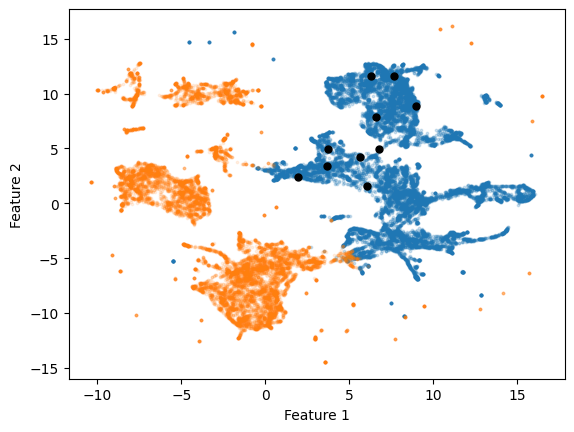

In [18]:
fig, ax = plt.subplots()

#print cluster 0 en bleu
scatter = ax.scatter(xx0[:, 0], xx0[:, 1], alpha=.2, c='C0', s=3)
#print cluster 1 en orange
ax.scatter(xx1[:, 0], xx1[:, 1], alpha=.1, c='C1', s=3)
#print liste manuelle en noir
ax.scatter(emb_labels[:, 0], emb_labels[:, 1], c='black', s=25)

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.show()

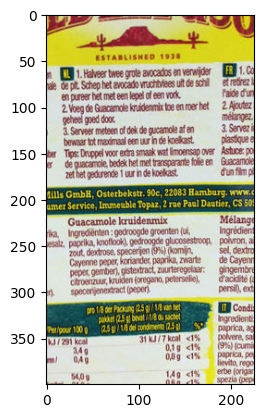

In [19]:
#[nb cluster][nb image]
file='../data/images/'+groups[0][30]
img = mpimg.imread(file)
plt.imshow(img)
plt.show()

Assignation de classe auto

In [85]:
with open('../data/embeddings/emb_light.pckl', 'rb') as f:
    emb_light = pickle.load(f)

In [86]:
emb_light_labels = np.array([emb_light[k] for k in list_labels])
emb_light_predict = kmeans.predict(emb_light_labels)
emb_light_predict

ValueError: X has 100 features, but KMeans is expecting 32960 features as input.

CREATION DATAFRAME

In [ ]:
# 'ID:nom_fichier', 'class', 'etiquette', 'embeddings_proj2D'

In [261]:
dataframe=[]
for i in range(len(groups)):
    if i==0:
        for j in zip(filenames, "class_"+str(i), xx0):
            dataframe.append(j)
    else:
        for j in zip(filenames,'class_'+str(i),xx1):
            dataframe.append(j)